# 2nd place solution of the 2021 NCAAW Competition

Solution write-up is available here : https://www.kaggle.com/c/ncaaw-march-mania-2021/discussion/230705

In [1]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *

pd.set_option('display.max_columns', None)

In [2]:
DATA_PATH = '../input/ncaaw-march-mania-2021/WDataFiles_Stage2/'

for filename in os.listdir(DATA_PATH):
    print(filename)

Conferences.csv
WNCAATourneyDetailedResults.csv
WRegularSeasonCompactResults.csv
WGameCities.csv
WNCAATourneySlots.csv
Cities.csv
WTeams.csv
WNCAATourneyCompactResults.csv
WSeasons.csv
WNCAATourneySeeds.csv
WRegularSeasonDetailedResults.csv
WSampleSubmissionStage2.csv
WTeamSpellings.csv
WTeamConferences.csv


# Data preparation

## Seeds
> This file identifies the seeds for all teams in each NCAA® tournament, for all seasons of historical data. Thus, there are between 64-68 rows for each year, depending on whether there were any play-in games and how many there were. In recent years the structure has settled at 68 total teams, with four "play-in" games leading to the final field of 64 teams entering Round 1 on Thursday of the first week (by definition, that is DayNum=136 each season). We will not know the seeds of the respective tournament teams, or even exactly which 68 teams it will be, until Selection Sunday on March 15, 2020 (DayNum=132).

> The seed is a 3/4-character :
- First character : Region (W, X, Y, or Z)
- Next two digits : Seed within the region (01 to 16)
- Last character (optional): Distinguishes teams between play-ins ( a or b)

In [3]:
df_seeds = pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv")
df_seeds.head()

,Season,Seed,TeamID
0,1998,W01,3330
1,1998,W02,3163
2,1998,W03,3112
3,1998,W04,3301
4,1998,W05,3272


## Season results
> This file identifies the game-by-game results for many seasons of historical data, starting with the 1985 season (the first year the NCAA® had a 64-team tournament). For each season, the file includes all games played from DayNum 0 through 132. It is important to realize that the "Regular Season" games are simply defined to be all games played on DayNum=132 or earlier (DayNum=132 is Selection Sunday, and there are always a few conference tournament finals actually played early in the day on Selection Sunday itself). Thus a game played on or before Selection Sunday will show up here whether it was a pre-season tournament, a non-conference game, a regular conference game, a conference tournament game, or whatever.

In [4]:
df_season_results = pd.read_csv(DATA_PATH + "WRegularSeasonCompactResults.csv")
df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [5]:
df_season_results['ScoreGap'] = df_season_results['WScore'] - df_season_results['LScore']

In [6]:
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,ScoreGap
0,1998,18,3104,91,3202,41,50
1,1998,18,3163,87,3221,76,11
2,1998,18,3222,66,3261,59,7
3,1998,18,3307,69,3365,62,7
4,1998,18,3349,115,3411,35,80


### Features 
For each team at each season, I compute : 
- Number of wins
- Number of losses
- Average score gap of wins
- Average score gap of losses

And use the following features : 
- Win Ratio
- Average score gap

In [7]:
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

In [8]:
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

In [9]:
gap_win = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})

In [10]:
gap_loss = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})

Merge

In [11]:
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

In [12]:
df_features_season = pd.concat([df_features_season_w, df_features_season_l], 0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

In [13]:
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')

In [14]:
df_features_season.fillna(0, inplace=True)  

Compute features

In [15]:
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['GapWins'] - 
    df_features_season['NumLosses'] * df_features_season['GapLosses'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

In [16]:
df_features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses'], axis=1, inplace=True)

## Tourney results

> This file identifies the game-by-game NCAA® tournament results for all seasons of historical data. The data is formatted exactly like the MRegularSeasonCompactResults data. All games will show up as neutral site (so WLoc is always N). Note that this tournament game data also includes the play-in games (which always occurred on day 134/135) for those years that had play-in games. Thus each season you will see between 63 and 67 games listed, depending on how many play-in games there were.

In [17]:
df_tourney_results = pd.read_csv(DATA_PATH + "WNCAATourneyCompactResults.csv")
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

## FiveThirtyEight Ratings
> Thanks to Raddar ! https://www.kaggle.com/raddar/ncaa-women-538-team-ratings

In [18]:
df_538 = pd.read_csv("../input/ncaa-women-538-team-ratings/538ratingsWomen.csv")
df_538.drop('TeamName', axis=1, inplace=True)

df_538.head()

,Season,TeamID,538rating
0,2016,3163,113.09
1,2016,3124,101.59
2,2016,3323,101.07
3,2016,3376,101.07
4,2016,3268,99.01


# Feature Engineering

## Train data

In [19]:
df = df_tourney_results.copy()
df = df[df['Season'] >= 2016].reset_index(drop=True)

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,2016,137,3107,61,3196,59
1,2016,137,3113,74,3308,52
2,2016,137,3120,68,3385,57
3,2016,137,3124,89,3225,59
4,2016,137,3177,97,3241,67


### Seeds
- `SeedW` is the seed of the winning team
- `SeedL` is the seed of the losing team

In [20]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

In [21]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

In [22]:
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

In [23]:
df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

In [24]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2016,137,3107,61,3196,59,12,5
1,2016,137,3113,74,3308,52,2,15
2,2016,137,3120,68,3385,57,9,8
3,2016,137,3124,89,3225,59,1,16
4,2016,137,3177,97,3241,67,6,11


### Season Stats
- `WinRatioW` is the win ratio of the winning team during the season
- `WinRatioL` is the win ratio of the losing team during the season

In [25]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'GapWins': 'GapWinsW',
    'GapLosses': 'GapLossesW',
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
}).drop(columns='TeamID', axis=1)

In [26]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'GapWins': 'GapWinsL',
    'GapLosses': 'GapLossesL',
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL',
}).drop(columns='TeamID', axis=1)

In [27]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,WinRatioW,GapAvgW,WinRatioL,GapAvgL
0,2016,137,3107,61,3196,59,12,5,0.870968,18.677419,0.733333,8.700000
1,2016,137,3113,74,3308,52,2,15,0.806452,9.258065,0.857143,8.964286
2,2016,137,3120,68,3385,57,9,8,0.612903,3.032258,0.718750,6.812500
3,2016,137,3124,89,3225,59,1,16,0.970588,24.617647,0.709677,10.612903
4,2016,137,3177,97,3241,67,6,11,0.757576,16.272727,0.843750,15.406250


### FiveThirtyEight Ratings
- `538ratingW` is the rating of the winning team during the season
- `538ratingL` is the rating of the losing team during the season

In [28]:
df = pd.merge(
    df,
    df_538,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingW'})

In [29]:
df = pd.merge(
    df, 
    df_538, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingL'})

In [30]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,WinRatioW,GapAvgW,WinRatioL,GapAvgL,538ratingW,538ratingL
0,2016,137,3107,61,3196,59,12,5,0.870968,18.677419,0.733333,8.700000,80.90,83.36
1,2016,137,3113,74,3308,52,2,15,0.806452,9.258065,0.857143,8.964286,91.32,71.42
2,2016,137,3120,68,3385,57,9,8,0.612903,3.032258,0.718750,6.812500,80.17,82.19
3,2016,137,3124,89,3225,59,1,16,0.970588,24.617647,0.709677,10.612903,101.59,72.69
4,2016,137,3177,97,3241,67,6,11,0.757576,16.272727,0.843750,15.406250,90.08,83.04


### Add symetrical
- Right now our data only consists of won matches
- We duplicate our data, get rid of the winner loser 

In [31]:
def add_loosing_matches(df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
     }
    win_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('W')})
    win_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('L')})
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
    }
    lose_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('W')})
    lose_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('L')})
    
    win_df = df.copy()
    lose_df = df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], 0, sort=False)

In [32]:
df = add_loosing_matches(df)

In [33]:
df.head()

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,538ratingA,538ratingB
0,2016,137,3107,61,3196,59,12,5,0.870968,18.677419,0.733333,8.700000,80.90,83.36
1,2016,137,3113,74,3308,52,2,15,0.806452,9.258065,0.857143,8.964286,91.32,71.42
2,2016,137,3120,68,3385,57,9,8,0.612903,3.032258,0.718750,6.812500,80.17,82.19
3,2016,137,3124,89,3225,59,1,16,0.970588,24.617647,0.709677,10.612903,101.59,72.69
4,2016,137,3177,97,3241,67,6,11,0.757576,16.272727,0.843750,15.406250,90.08,83.04


### Differences
- We compute the difference between the team for each feature.
- This helps further assessing how better (or worse) team A is from team B

In [34]:
cols_to_diff = [
    'Seed', 'WinRatio', 'GapAvg', '538rating'
]

for col in cols_to_diff:
    df[col + 'Diff'] = df[col + 'A'] - df[col + 'B']

## Test Data

### Preparing

In [35]:
df_test = pd.read_csv(DATA_PATH + "WSampleSubmissionStage2.csv")

In [36]:
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIdA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIdB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

In [37]:
df_test.head()

,ID,Pred,Season,TeamIdA,TeamIdB
0,2021_3104_3112,0.5,2021,3104,3112
1,2021_3104_3116,0.5,2021,3104,3116
2,2021_3104_3124,0.5,2021,3104,3124
3,2021_3104_3125,0.5,2021,3104,3125
4,2021_3104_3133,0.5,2021,3104,3133


### Seeds

In [38]:
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'})

In [39]:
df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'TeamIdB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'})

In [40]:
df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)

### Season Stats

In [41]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsA',
    'NumLosses': 'NumLossesA',
    'GapWins': 'GapWinsA',
    'GapLosses': 'GapLossesA',
    'WinRatio': 'WinRatioA',
    'GapAvg': 'GapAvgA',
}).drop(columns='TeamID', axis=1)

In [42]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsB',
    'NumLosses': 'NumLossesB',
    'GapWins': 'GapWinsB',
    'GapLosses': 'GapLossesB',
    'WinRatio': 'WinRatioB',
    'GapAvg': 'GapAvgB',
}).drop(columns='TeamID', axis=1)

### Ratings

In [43]:
df_test = pd.merge(
    df_test,
    df_538,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingA'})

In [44]:
df_test = pd.merge(
    df_test,
    df_538,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingB'})

### Differences

In [45]:
for col in cols_to_diff:
    df_test[col + 'Diff'] = df_test[col + 'A'] - df_test[col + 'B']

In [46]:
df_test.head()

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,538ratingA,538ratingB,SeedDiff,WinRatioDiff,GapAvgDiff,538ratingDiff
0,2021_3104_3112,0.5,2021,3104,3112,7,3,0.64,4.76,0.761905,10.523810,84.22,93.87,4,-0.121905,-5.763810,-9.65
1,2021_3104_3116,0.5,2021,3104,3116,7,4,0.64,4.76,0.703704,9.000000,84.22,89.61,3,-0.063704,-4.240000,-5.39
2,2021_3104_3124,0.5,2021,3104,3124,7,2,0.64,4.76,0.925926,27.111111,84.22,100.75,5,-0.285926,-22.351111,-16.53
3,2021_3104_3125,0.5,2021,3104,3125,7,12,0.64,4.76,0.800000,12.320000,84.22,75.93,-5,-0.160000,-7.560000,8.29
4,2021_3104_3133,0.5,2021,3104,3133,7,11,0.64,4.76,0.592593,4.592593,84.22,76.78,-4,0.047407,0.167407,7.44


## Target

In [47]:
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

# Modeling

In [48]:
features = [
    'SeedDiff',
    '538ratingDiff',
    'WinRatioDiff', 
    'GapAvgDiff', 
]

In [49]:
def rescale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    if df_test is not None:
        df_test[features] = (df_test[features] - min_) / (max_ - min_)
        
    return df_train, df_val, df_test

### Cross Validation
- Validate on season `n`, for `n` in the 3 last seasons. 
- Train on earlier seasons. First available season is 2016 because of the FiveThirtyEight ratings.
- Pipeline support classification (predict the team that wins) and regression (predict the score gap), but classification worked better on CV.

In [50]:
def kfold(df, df_test_=None, plot=False, verbose=0, mode="reg"):
    seasons = df['Season'].unique()
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    for season in seasons[1:]:
        if verbose:
            print(f'\nValidating on season {season}')
        
        df_train = df[df['Season'] < season].reset_index(drop=True).copy()
        df_val = df[df['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test_.copy()
        
        df_train, df_val, df_test = rescale(features, df_train, df_val, df_test)
        
        if mode == "reg":
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            model = LogisticRegression(C=100)

        model.fit(df_train[features], df_train[target])
        
        if mode == "reg":
            pred = model.predict(df_val[features])
            pred = (pred - pred.min()) / (pred.max() - pred.min())
        else:
            pred = model.predict_proba(df_val[features])[:, 1]
        
        if df_test is not None:
            if mode == "reg":
                pred_test = model.predict(df_test[features])
                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                pred_test = model.predict_proba(df_test[features])[:, 1]
                
            pred_tests.append(pred_test)
            
        if plot:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.grid(True)
            plt.subplot(1, 2, 2)
            sns.histplot(pred)
            plt.show()
        
        loss = log_loss(df_val['WinA'].values, pred)
        cvs.append(loss)

        if verbose:
            print(f'\t -> Scored {loss:.3f}')
        
    print(f'\n Local CV is {np.mean(cvs):.3f}')
    
    return pred_tests

In [51]:
pred_tests = kfold(df, df_test, plot=False, verbose=1, mode="cls")


Validating on season 2017
	 -> Scored 0.404

Validating on season 2018
	 -> Scored 0.487

Validating on season 2019
	 -> Scored 0.358

 Local CV is 0.416


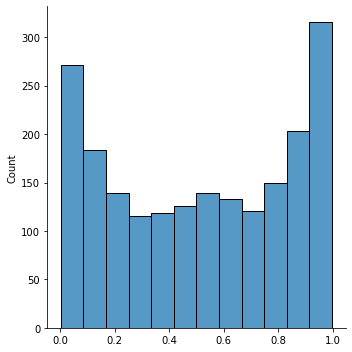

In [52]:
pred_test = np.mean(pred_tests, 0)

_ = sns.displot(pred_test)

# Overriding predictions

## Prepare

In [53]:
sub = df_test[['ID', 'Pred', 'TeamIdA', 'TeamIdB', 'SeedA', 'SeedB']].copy()
sub['Pred'] = pred_test

In [54]:
df_teams = pd.read_csv(DATA_PATH + "WTeams.csv")
sub = sub.merge(df_teams, left_on="TeamIdA", right_on="TeamID").drop('TeamID', axis=1).rename(columns={"TeamName": "TeamA"})
sub = sub.merge(df_teams, left_on="TeamIdB", right_on="TeamID").drop('TeamID', axis=1).rename(columns={"TeamName": "TeamB"})

In [55]:
if 'Season' in df_seeds.keys():
    df_seeds = df_seeds[df_seeds['Season'] == 2021].drop("Season", axis=1)
df_seeds['Seed'] = df_seeds['Seed'].apply(lambda x:x[0])

sub = sub.merge(df_seeds, left_on="TeamIdA", right_on="TeamID").drop('TeamID', axis=1).rename(columns={"Seed": "RegionA"})
sub = sub.merge(df_seeds, left_on="TeamIdB", right_on="TeamID").drop('TeamID', axis=1).rename(columns={"Seed": "RegionB"})

## Strategies

#### Risky strategy

- Picked 11 teams that would win their first match
- Stanford and Baylor beat every team seeded 3 or higher
- Connecticut and South Carolina  beat every team seeded 4 or higher
- Maryland wins beats every team seeded 7 or higher
- use p=0.99999 for overriding

#### Safe strategy

- Picked 7 teams that would win their first match
- Stanford, Connecticut and South Carolina beat every team seeded 6 or higher
- Baylor wins beats every team seeded 7 or higher
- use p=0.99 for overriding

In [56]:
best_teams = ['Stanford', 'South Carolina', 'Connecticut', 'Baylor', 'Maryland']  # considered for buff

strong_teams_safe = best_teams + ['NC State', 'Louisville']  # win 1st round
strong_teams_risky = strong_teams_safe + ['Texas A&M', 'Arizona', 'Georgia', 'UCLA']  # win 1st round

In [57]:
def overwrite_pred_risky(sub, eps=1e-5):

    new_sub = []
    
    for i, row in sub.iterrows():
        
        # Buff Stanford
        if row['TeamA'] == 'Stanford' and row['SeedB'] >= 3:
            row['Pred'] = 1 - eps
        elif row['TeamB'] == 'Stanford' and row['SeedA'] >= 3:
            row['Pred'] = eps
    
        # Buff South Carolina
        if row['TeamA'] == 'South Carolina' and row['SeedB'] >= 4:
            row['Pred'] = 1 - eps
        elif row['TeamB'] == 'South Carolina' and row['SeedA'] >= 4:
            row['Pred'] = eps
            
        # Buff Connecticut
        if row['TeamA'] == 'Connecticut' and row['SeedB'] >= 4:
            row['Pred'] = 1 - eps
        elif row['TeamB'] == 'Connecticut' and row['SeedA'] >= 4:
            row['Pred'] = eps
            
        # Buff Baylor
        if row['TeamA'] == 'Baylor' and row['SeedB'] >= 3:
            row['Pred'] = 1 - eps
        elif row['TeamB'] == 'Baylor' and row['SeedA'] >= 3:
            row['Pred'] = eps
            
        # Buff Maryland
        if row['TeamA'] == 'Maryland' and row['SeedB'] >= 7:
            row['Pred'] = 1 - eps
        elif row['TeamB'] == 'Maryland' and row['SeedA'] >= 7:
            row['Pred'] = eps
        
        # Strong teams (risky) win their first round
        if row['TeamA'] in strong_teams_risky and row['SeedB'] >= 13:
            row['Pred'] = 1 - eps
        elif row['TeamB'] in strong_teams_risky and row['SeedA'] >= 13:
            row['Pred'] = eps

        new_sub.append(row)
        
    return pd.DataFrame(np.array(new_sub), columns=sub.columns)

In [58]:
def overwrite_pred_safe(sub, eps=1e-2):    
    new_sub = []
    
    for i, row in sub.iterrows():
        row['Pred'] = np.clip(row['Pred'], 0.1, 0.9) # clip for safety
        
        # Buff Stanford
        if row['TeamA'] == 'Stanford' and row['SeedB'] >= 6:
            row['Pred'] = 1 - eps
        elif row['TeamB'] == 'Stanford' and row['SeedA'] >= 6:
            row['Pred'] = eps
    
        # Buff South Carolina
        if row['TeamA'] == 'South Carolina' and row['SeedB'] >= 6:
            row['Pred'] = 1 - eps
        elif row['TeamB'] == 'South Carolina' and row['SeedA'] >= 6:
            row['Pred'] = eps
            
        # Buff Connecticut
        if row['TeamA'] == 'Connecticut' and row['SeedB'] >= 6:
            row['Pred'] = 1 - eps
        elif row['TeamB'] == 'Connecticut' and row['SeedA'] >= 6:
            row['Pred'] = eps

        # Buff Baylor
        if row['TeamA'] == 'Baylor' and row['SeedB'] >= 7:
            row['Pred'] = 1 - eps
        elif row['TeamB'] == 'Baylor' and row['SeedA'] >= 7:
            row['Pred'] = eps
        
        # Strong teams (safe) win their first rounds
        if row['TeamA'] in strong_teams_safe and row['SeedB'] >= 13:
            row['Pred'] = 1 - eps
        elif row['TeamB'] in strong_teams_safe and row['SeedA'] >= 13:
            row['Pred'] = eps

        new_sub.append(row)
        
    return pd.DataFrame(np.array(new_sub), columns=sub.columns)

In [59]:
# sub_pp = overwrite_pred_safe(sub)
sub_pp = overwrite_pred_risky(sub)

## Submission

In [60]:
final_sub = sub_pp[['ID', 'Pred']].copy()
final_sub.to_csv('submission.csv', index=False)

In [61]:
final_sub.head()

,ID,Pred
0,2021_3104_3112,0.248928
1,2021_3104_3116,0.337936
2,2021_3112_3116,0.606634
3,2021_3104_3124,0.000010
4,2021_3112_3124,0.000010
